# Mining TripAdvisor users opinions about restaurants

#### In this section of the project, it will be extracted the sentiments of the reviews for each restaurant, using Natural Language Processing (NLP) tools for Python.

## Part 1: Extracting the text data

In order to perform a sentiment analysis in any text data it is necessary to have this text data in an appropriate form.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pymongo

import time
import datetime as dt
%matplotlib inline

In [2]:
# Oppening the MongoDB Altas Connection
f = open('/media/michel/dados/Projects/emails.txt', 'r')
passwd = f.read().splitlines()[2]
my_mongo_url = passwd

# Creating a Client
client = pymongo.MongoClient(my_mongo_url, serverSelectionTimeoutMS=5000)
db = client.restaurant_reviews

# Testing connection
db.reviews_I.find_one()

{'_id': ObjectId('6122570ffbd547706864808a'),
 'restaurant_name': 'Camarada Camar√£o - Shopping Recife',
 'rating': 5.0,
 'number_of_ratings': 3792,
 'review_title': 'Encontro amigos!',
 'review_date': 'Publicada ontem',
 'reviewer_Name': 'karolrevoredoo',
 'review': 'O ambiente √© maravilhoso! E o atendimento do gar√ßom Edvaldo √© incr√≠vel, muito atencioso e solicito! O Gerente Amaro Rocha √© muito cordial!',
 'reviews_scores': {'Excellent': 3073,
  'Very Good': 556,
  'Good': 63,
  'Bad': 19,
  'Terrible': 15}}

In [4]:
some_reviews = db.reviews_I.find({}).limit(5)
for review in some_reviews:
    print(review)

{'_id': ObjectId('6122570ffbd547706864808a'), 'restaurant_name': 'Camarada Camar√£o - Shopping Recife', 'rating': 5.0, 'number_of_ratings': 3792, 'review_title': 'Encontro amigos!', 'review_date': 'Publicada ontem', 'reviewer_Name': 'karolrevoredoo', 'review': 'O ambiente √© maravilhoso! E o atendimento do gar√ßom Edvaldo √© incr√≠vel, muito atencioso e solicito! O Gerente Amaro Rocha √© muito cordial!', 'reviews_scores': {'Excellent': 3073, 'Very Good': 556, 'Good': 63, 'Bad': 19, 'Terrible': 15}}
{'_id': ObjectId('61225710fbd547706864808c'), 'restaurant_name': 'Camarada Camar√£o - Shopping Recife', 'rating': 5.0, 'number_of_ratings': 3792, 'review_title': '√ìtima experi√™ncia', 'review_date': 'Publicada h√° 2 dias', 'reviewer_Name': 'Leticia C', 'review': 'Muito bem atendidos pelo √Çngelo Atendimento √°gil, simp√°tico e prato muito saboroso Restaurante do shopping Recife Recomendamos', 'reviews_scores': {'Excellent': 3073, 'Very Good': 556, 'Good': 63, 'Bad': 19, 'Terrible': 15}}
{'_

So, to extract only the review text of each document:

In [5]:
some_reviews = db.reviews_I.find({}).limit(5)
for review in some_reviews:
    print(f'Review: {review["review"]}\n')

Review: O ambiente √© maravilhoso! E o atendimento do gar√ßom Edvaldo √© incr√≠vel, muito atencioso e solicito! O Gerente Amaro Rocha √© muito cordial!

Review: Muito bem atendidos pelo √Çngelo Atendimento √°gil, simp√°tico e prato muito saboroso Restaurante do shopping Recife Recomendamos

Review: Comida fant√°stica, muito bem servida e ambiente extremamente agrad√°vel. Gar√ßons muito educados e super atenciosos.

Review: Culin√°ria de frutos do mar impec√°vel. Camar√£o ao Gergelim delicioso. Atendimento de Mayara excelente. Ambiente decorado com muito cuidado.

Review: Nota 10, atendente muito simp√°tica e prestativa, chamava Nayara. Ambiente super aconchegante e a comida muito boa



Now we turn our attention to extracting some value from this reviews.

### 4. What are the most common words in the reviews titles?

In order to answer that question it will be necessary to concatenate all the reviews titles in one string and then perform a Term Frequency count in those words.
First we extract all the reviews titles from the data base and store in a list:

In [6]:
# Concateneting all the reviews titles in one string
# This process can take some time. Maybe it is a good ideia to measure it
words = []
all_reviews = db.reviews_I.find({})

st = time.monotonic()
for review in all_reviews:
    words.append(review["review_title"])
    
et = time.monotonic()
det = dt.timedelta(seconds = et - st)
print(f"Total processing time: {det}.")
print(f"Found {len(words)} titles")

Total processing time: 0:00:08.328496.
Found 30746 titles


And then we join everything together in a string.


In [8]:
# And now concatenating the reviews
titles = ' '.join(words)
print(titles[:100])

Encontro amigos! √ìtima experi√™ncia Almo√ßo Almo√ßo casal Nota 10 Excelente para qualquer ocasi√£o Almo√ß


#### Now our Natural Language processing starts. First we have to import all the necessary tools.

In [7]:
# Now importing the NLP toolkit 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

The first step when proceding with a NLP is to transform the data. First, we have to remove the stop words from the text. That can me made with the stopwords() function from the Natural Languague Processing Toolkit. Since the text is in portuguese language, we will have to specify it as an argument.

In [8]:
# Show the portuguese stopwords
print(stopwords.words('portuguese'))

['de', 'a', 'o', 'que', 'e', '√©', 'do', 'da', 'em', 'um', 'para', 'com', 'n√£o', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', '√†', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'j√°', 'eu', 'tamb√©m', 's√≥', 'pelo', 'pela', 'at√©', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'voc√™', 'essa', 'num', 'nem', 'suas', 'meu', '√†s', 'minha', 'numa', 'pelos', 'elas', 'qual', 'n√≥s', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'voc√™s', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'est√°', 'estamos', 'est√£o', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'est√°vamos', 'estavam', 'estivera', 'estiv√©ramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estiv√©ssemos', 'estivessem', '

Now let's remove these stopwords from the titles

In [9]:
# Instantiating the stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.update(["!", ".", ","])               # Removing some punctuations

# Spliting the big string into its words
titles_tokens = word_tokenize(titles)

# Using list comprehension to create a new list without the stopwords
filtered_titles = [title.lower() for title in titles_tokens if not title.lower() in stop_words]

Basically, this procedure is checking if a word in title *titles_tokens* is not in the *stop_words* list. If it is not, then it will be added to our *filtered_titles* list. The result in a bag of words.

Now we can generate a wordcloud to visualize the most common words in the reviews titles:

In [10]:
titles_cloud = WordCloud(max_words=50,
                         background_color='white',
                         prefer_horizontal=0.5,
                        width=800,
                        height=400,
                        colormap='Greens').generate(' '.join(filtered_titles))

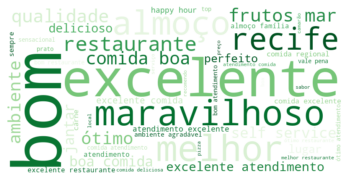

In [11]:
plt.imshow(titles_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud1.png')

Great! This word cloud shows us that the majority of the reviews titles relates to the rating of the restaurant. Being "Excellent" the title most attributed to the user experience. Then comes "Good", "Best", "Wonderful". The other group of titles relates to the type of meal that users were having, like "Lunch" and "Dinner".
It is also possible to create a bar plot to show the exact frequency of the words. For that, we have to count the frequency of each word, also known as Term Frequency.

In [12]:
# Let's calculate Term Frequency manually
TF = []

# This loop itereates through the set of filtered titles. A set is a data structure that stores only unique values
# It calculates how many each unique word appears in the filtered_titles
for word in set(filtered_titles):
    TF.append(filtered_titles.count(word))

# Transforming the set of unique words into a list
terms = list(set(filtered_titles))

As there are a lot of words, lets only use the words with frequency more than 500, for example.

In [13]:
min_freq=500

# Filtering only the frequencies bigger than min_freq
top_500_frequencies = [tf for tf in TF if tf > min_freq]

In [14]:
# Now filtering only the terms that correspondes do the top_500_frequencies
top_500_terms = []

# This loop iteretes over the terms list, and for each index of the terms list, it checks if the term with the same
# index in the TF is bigger than the min_freq. If it is, then it will be added to the new list
for j in range(len(terms)):
    if TF[j] > min_freq:
        top_500_terms.append(terms[j])

Lets print some sample values to see what is going on

In [15]:
for k in range(10):
    print(f'{top_500_terms[k]}: {top_500_frequencies[k]}')

melhor: 1548
bom: 2952
agrad√°vel: 732
qualidade: 613
jantar: 1348
√≥tima: 607
mar: 505
maravilhoso: 719
ambiente: 908
√≥timo: 1106


And now lets visualize the terms that appears more than 500 in the reviews titles

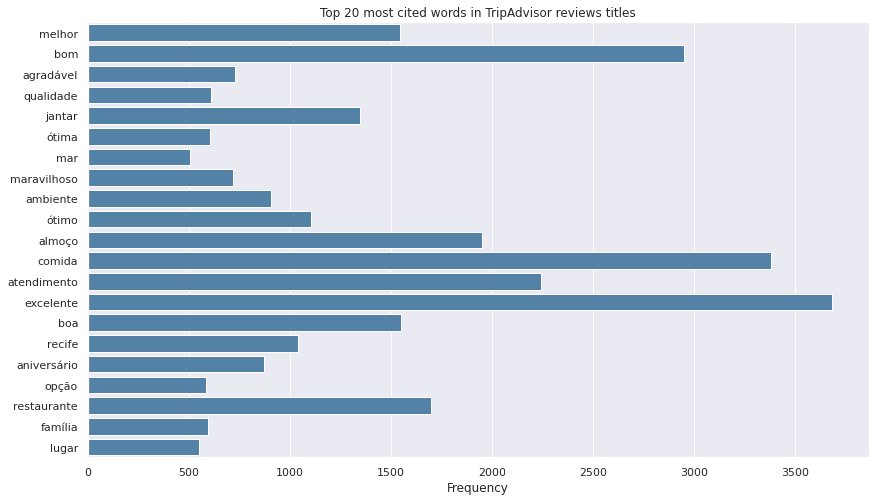

In [16]:
sns.set_theme('notebook')
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(y=top_500_terms,
            x=top_500_frequencies,
           color='steelblue')
ax.set(title='Top 20 most cited words in TripAdvisor reviews titles',
       xlabel='Frequency')
plt.show()

There is a easier way to do that, all we have to do is create a dataframe and then we can easily plot graphs and sort values.

In [17]:
# Creating a dataframe out of lists
df_tf = pd.DataFrame(data=list(zip(terms, TF)), columns=['Term', 'Frequency'])
df_tf.sort_values(by='Frequency', ascending=False)

Term  Frequency
3192        excelente       3682
2819           comida       3380
172               bom       2952
3061      atendimento       2244
2785           almo√ßo       1952
...               ...        ...
1370           junino          1
1369   relacionamento          1
3225  cachorro-quente          1
1368               aa          1
0             receber          1

[5327 rows x 2 columns]

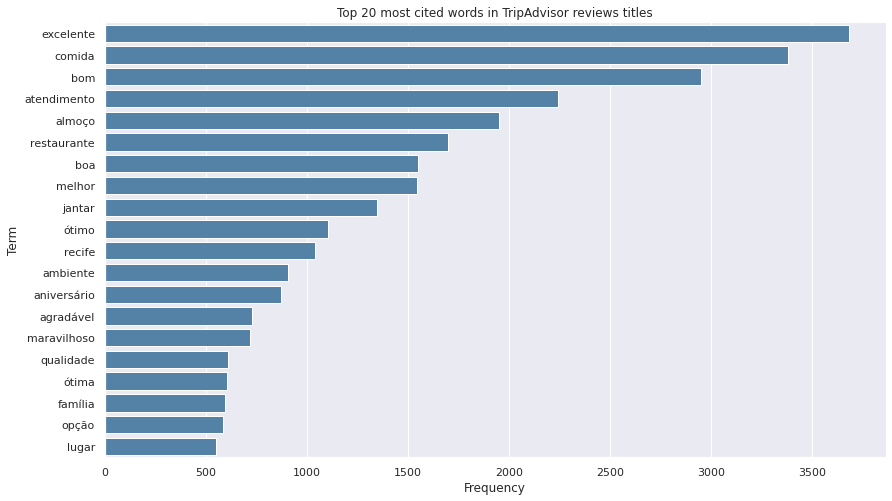

In [18]:
# Now lets redo the bar plot showing the top 20 words
df_tf_top_20 = df_tf.sort_values(by='Frequency', ascending=False)[:20]
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_tf_top_20,
           x='Frequency',
           y='Term',
           color='steelblue',
           )
ax.set(title='Top 20 most cited words in TripAdvisor reviews titles',
      xlabel='Frequency')
plt.show()

That answers our forth question.

### 5. What are the most common words in the reviews texts?
To answer that question we can follow the same path as we did in the reviews titles. But now let's first apply the Sentiment Analysis to the reviews and split apart the positive reviews from the negatives and from the neutral reviews.
To reach that, lets create a dataframe that stores each review text in row. Then, we extract the sentiment and store it in another column. This way we can filter between each of the sentiments.

#### Creating a DataFrame with all the reviews texts
Lets rerun the query that retrieves all the reviews texts

In [19]:
# Querying the database
all_reviews = db.reviews_I.find({})

# Create a empty list to store the text
reviews = []

# Iterate over the cursor do extract the review
for review in all_reviews:
    reviews.append(review['review'])

# Show a sample result
reviews[:10]

['O ambiente √© maravilhoso! E o atendimento do gar√ßom Edvaldo √© incr√≠vel, muito atencioso e solicito! O Gerente Amaro Rocha √© muito cordial!',
 'Muito bem atendidos pelo √Çngelo Atendimento √°gil, simp√°tico e prato muito saboroso Restaurante do shopping Recife Recomendamos',
 'Comida fant√°stica, muito bem servida e ambiente extremamente agrad√°vel. Gar√ßons muito educados e super atenciosos.',
 'Culin√°ria de frutos do mar impec√°vel. Camar√£o ao Gergelim delicioso. Atendimento de Mayara excelente. Ambiente decorado com muito cuidado.',
 'Nota 10, atendente muito simp√°tica e prestativa, chamava Nayara. Ambiente super aconchegante e a comida muito boa',
 'Excelente o gratinado imperial!!! D√° pra tr√™s pessoas que n√£o comem muito tranquilo. Atendimento tamb√©m √© bom e o ambiente √© bem bonito.',
 'Excelente!! Luciana atende com dedica√ß√£o e aten√ß√£o, uma querida!! Amaro Rocha muito atencioso e tomando conta do atendimento o tempo todo. Parab√©ns ao Camarada Camar√£o do shopp

And now we add that to a new dataframe

In [20]:
reviews_df = pd.DataFrame(reviews, columns=['review'])
reviews_df.head()

review
0  O ambiente √© maravilhoso! E o atendimento do g...
1  Muito bem atendidos pelo √Çngelo Atendimento √°g...
2  Comida fant√°stica, muito bem servida e ambient...
3  Culin√°ria de frutos do mar impec√°vel. Camar√£o ...
4  Nota 10, atendente muito simp√°tica e prestativ...

Now let's start with the Natural Language processing procedure. First and foremost, import the libraries

In [21]:
from textblob import TextBlob
import re

The sentiment analysis will not work well in the portuguese language, so let's try to translate it to english. The result may not be the best, but give it a try.

In [22]:
# pip install googletrans==4.0.0-rc1
from googletrans import Translator, constants

In [24]:
translator = Translator()
def translate_reviews(row):
    """
    This function translates a review from the original
    languague (portuguese in this case)
    to english
    """
    try:
        translated_review = translator.translate(row).text
        return translated_review   
    
    except:
        print(f"something went wrong with the frase: {row}---")

In [25]:
st = time.monotonic()
reviews_df['text'] = reviews_df['review'].apply(translate_reviews)
et = time.monotonic()
td = dt.timedelta(seconds = et - st)
print("Processing Time: ", td)
reviews_df.to_csv('reviews_df.csv', index=False)

something went wrong with the frase: Atendimento muito bom, atendente muito simp√°tica a Juliana Karla. Tudo √≥timo. Indico muito se vc estiver aqui nas redondezas do shopping recife provar.---
something went wrong with the frase: Gostei muito dorestaurante, excelente atendimento do gar√ßom lenilson e o metri Robson, espa√ßo muito agrad√°vel.---
something went wrong with the frase: Atendimento excelente do Valbens. Comida maravilhosa, carne super macia e tempero excelente. Voltarei sempre.---
something went wrong with the frase: Servi√ßo de √çcaro e do senhor Lima s√£o excelente! Podem procurar por eles. Ambiente muito aconchegante e a cerveja sempre gelada.---
something went wrong with the frase: √ìtimo atendimento do Ikaro!! Cerveja gelada, ambiente agrad√°vel, eu quero vim sempre aqui e ser atendido pelo Ikaro.---
something went wrong with the frase: Eles s√£o topa principalmente √çcaro e sei Lima os dois precisam ser promovidos, fui atendida da melhor forma poss√≠vel---
something w

something went wrong with the frase: Oi Malu!! Ficamos felizes por termos agradado a sua prefer√™ncia. As suas observa√ß√µes ser√£o muito bem avaliadas. Agradecemos a sua escolha e esperamos poder receb√™-la aqui novamente na casa do Bodinho, ser√° muito bem-vinda!---
something went wrong with the frase: De frente √† praia de Olinda/PE, fui almo√ßar com a fam√≠lia no Bode do N√¥. Fui muito bem recebido pelos funcion√°rios atenciosos, sentamos e logo a comida foi servida, deliciosa a um pre√ßo justo. Recomendo aos viajantes, vale a pena!---
something went wrong with the frase: Pela segunda vez estive no Bode do N√¥ de Boa Viagem e o sentimento foi o mesmo da primeira vez: um lugar amplo, agrad√°vel, bem estruturado, com um vasto card√°pio, cujo atendimento e qualidade dos pratos destoam do ambiente. Gar√ßons mal humorados, prato com qualidade...Mais---
something went wrong with the frase: Conhecemos o restaurante pelas redes sociais e quando viajamos pra Recife fomos conhecer,amamos o a

something went wrong with the frase: Tudo muito bom e a comida espetacular... Antonio, melhor gar√ßom!!Super recomendo, ambiente muito agradavel com criancas inclusi e!!---
something went wrong with the frase: Agradecemos sua visita e avalia√ß√£o. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua pr√≥xima visita.---
something went wrong with the frase: Bom demais! O bode √© show de bola. Fomos atendidos por Eliomar. Muito gentil o gar√ßom. Voltaremos com certeza.---
something went wrong with the frase: Agradecemos sua visita e avalia√ß√£o. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua pr√≥xima visita.---
something went wrong with the frase: Tem que ir l√°. Bem localizado, com estacionamento, em frente ao mar. Comida nordestina, lugar muito bem decorado, muitas op√ß√µes de refei√ß√µes ou por√ß√µes. Bom atendimento. Boa comida. Bom lugar. O que mais precisa? Pre√ßos condizentes com o que √© oferecido. Com certeza volto l√°.---
somet

something went wrong with the frase: Agradecemos sua visita e avalia√ß√£o. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua pr√≥xima visita.---
something went wrong with the frase: Restaurante bonito, bem movimentado, com √≥timas op√ß√µes para quem quer experimentar o bode. Recomendo.---
something went wrong with the frase: Agradecemos sua visita e avalia√ß√£o. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua pr√≥xima visita.---
something went wrong with the frase: Uma culin√°ria bem regional, por√©m muito sofisticado. Com sobremesas deliciosas que enchem aos nossos olhos.---
something went wrong with the frase: Agradecemos sua visita e avalia√ß√£o. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua pr√≥xima visita.---
something went wrong with the frase: Local agrad√°vel, bem recomendado pelo nosso representante, por√©m esperava mais do local. Chopp n√£o estava no ponto, por√©m o atendimento foi bom.---
som

something went wrong with the frase: Sr. Jos√© Carlos, ver nossos clientes satisfeitos √© nossa maior meta e sempre faremos tudo que est√° ao nosso alcance para entregar um trabalho impec√°vel. Obrigado!---
something went wrong with the frase: Comida deliciosa, ambiente aconchegante, bons e variados drinks. Al√©m de contar com um bom atendimento!---
something went wrong with the frase: Sra. Joana, foi um prazer receber sua visita. Esperamos que tenha gostado e que a qualidade do nosso trabalho justifique uma pr√≥xima visita. At√© breve!---
something went wrong with the frase: excelente restaurante, com boas op√ß√µes de comidas e com uma carta de drinks e vinhos muito bem escolhida.---
something went wrong with the frase: Sr. Paulo, √© uma enorme alegria saber que depositou em n√≥s sua confian√ßa e que viu no trabalho que desempenhamos algo que ia de encontro √†s suas necessidades. Muito obrigado.---
something went wrong with the frase: Ambiente aconchegante e servi√ßo exemplar. Fomos m

something went wrong with the frase: Vlw Renato! obrigado pelo feedback!---
something went wrong with the frase: Produtos deliciosos, bom atendimento e entrega pontual e entregador atencioso e simp√°tico. O ponto f√≠sico √© aconchegante e familiar. E o melhor: pre√ßo excelente.---
something went wrong with the frase: Obrigado pelo feedback Lidia! procuramos sempre dar o melhor de n√≥s no atendimento e avaliacoes como a sua nos fazem a fazer cada vez sempre o melhor!---
something went wrong with the frase: Comida maravilhosa, excelente entrega e atendimento. Tudo no precinho e com qualidade, todo mundo adorou---
something went wrong with the frase: Obrigado pelo feedback Eduarda! qualidade √© o nosso foco!---
something went wrong with the frase: Hamb√∫rgueres deliciosos,com um bom atendimento.(entrega dentro do hor√°rio previsto) E para quem quer ir direto a bigode lanches √© um ambiente aconchegante bem fam√≠lia.---
something went wrong with the frase: Obrigado pelo feedback! procuramo

something went wrong with the frase: Levamos nossos amigos canadenses para saborear alguns pratos t√≠picos da nossa cozinha. No self Service variado provamos pratos deliciosos excelente sobremesas. Vale a pena esperar a fila e se deliciar nesse sabor üòã---
something went wrong with the frase: Sem d√∫vida, o melhor self-service de Boa Viagem. Comida caprichada, sempre de melhor qualidade, Decoracao linda, atendimento excelente. N√£o √© barato, mas a comida vale a visita. N√£o deixe de experimentar a salada de manga üòã---
something went wrong with the frase: Um bom restaurante, com op√ß√µes bem variadas pra quem tem restri√ß√µes, tem sopas e muitas saladas, comida muito gostosa, lugar muito bonito e aconchegante, pre√ßo meio salgado!---
something went wrong with the frase: A comida √© bem saborosa e o buffet possui op√ß√µes diversificadas. O pre√ßo √© m√©dio. V√°rias op√ß√µes de salada.---
something went wrong with the frase: Muit√≠ssimo boa comida. Considero um dos melhores self ser

something went wrong with the frase: Todos (4) muito satisfeitos com o que comeram. Ambiente climatizado e com bela decora√ß√£o. Pre√ßo justo.---
something went wrong with the frase: Fomos s√°bado almo√ßar e provamos muita coisa , o fil√© , a picanha e at√© frutos do mar, acompanhados de muito verde e um arroz com br√≥colis maravilhoso.---
something went wrong with the frase: Sem d√∫vida, o Chica Pitanga tem a maior e melhor variedade de pratos na modalidade self service em Boa Viagem. Pratos requintados e deliciosos explicam a espera por uma mesa no restaurante nos fins de semana.---
something went wrong with the frase: Bem proximo a praca este restaurante impressionou pela simpatia e qualidade da comida. Otimo tempero e estilo self sevice. Preco um pouco alto mas vale pela produto oferecido.---
something went wrong with the frase: Nova visita a Recife. Hospedado em Boa Viagem, convite para almo√ßar no Chica Pitanga. Vale cada moeda. Atendimento muito simp√°tico j√° na recep√ß√£o. O m

something went wrong with the frase: Pr√≥s: 1 - Comida muito bem feita e ingredientes de excelente qualidade. 2 - Restaurante totalmente climatizado e agrad√°vel. (Sala da Fila de espera com ar condicionado) 3 - Atendimento simp√°tico. 4 - Decora√ß√£o inusitada e divertida. 5 - F√°cil localiza√ß√£o. Contras: 1 - Pre√ßo...Mais---
something went wrong with the frase: O local √© magn√≠fico, a comida √© maravilhosa; acho ser o melhor de Recife. O local e o atendimento s√£o nota 10.---
something went wrong with the frase: comida variada e muito saborosa. Por ser por quilo √© uma √≥tima op√ß√£o para o almo√ßo em boa viagem. Apesar da fila de espera, fomos chamados em menos de 20 minutos.---
something went wrong with the frase: O restaurante √© de f√°cil acesso. Al√©m disso, a comida √© espetacular com uma variedade sensacional. Temperatura ideal. O atendimento √© muito bom! Imperd√≠vel!!!---
something went wrong with the frase: Restaurante bem bonito, comida variada e gostosa! Fica em boa vi

something went wrong with the frase: Lugar agrad√°vel, boa variedade de comida, bom atendimento. Pre√ßo um pouco alto, mas compensa pelo que oferece. Uma boa pedida em Recife!---
something went wrong with the frase: Restaurante self service com comida variada e saborosa. O sal√£o √© bem decorado, por√©m o atendimento bem fraco. Vale conhecer para uma refei√ß√£o r√°pida. Achei o pre√ßo justo.---
something went wrong with the frase: A comida sempre espetacular faz valer a pena a viagem at√© Recife. Como gosto de comer bem e ser bem atendido Recomendo muito, especialmente no almo√ßo---
something went wrong with the frase: Excelente ...RECOMENDO! Qualidade de saladas e carnes com preco justo. Otima localizacao...muita variedade---
something went wrong with the frase: Self service de alto padr√£o com comidas requintadas e excelentes combina√ß√µes. Risotos, bob√≥ de camar√£o, peixes, carnes...tudo de primeira qualidade. O pre√ßo √© um pouco alto mas vale a pena. Fui num domingo com os amigos

something went wrong with the frase: Chegamos no aeroporto na hora do almo√ßo. Antes de viajar para maracaipe decidimos almo√ßar em Recife. O restaurante surpreendeu. Comida boa e de qualidade. Valor n√£o √© barato mas compensa. Recomendo e voltaria com certeza---
something went wrong with the frase: Tradicional self-service da zona sul da cidade, Chica Pitanga n√£o perdeu em nada a qualidade de seu per√≠odo de ouro. No cora√ß√£o da zona sul da cidade, o restaurante oferece comida de boa qualidade para refei√ß√µes familiares e de neg√≥cios.---
something went wrong with the frase: Restaurante com uma culin√°ria maravilhosa. Tem comida regional, saladas, frutos do mar... Tudo muito gostoso. O pre√ßo √© salgado...---
something went wrong with the frase: O restaurante e √≥timo e os funcion√°rios muito atenciosos. Buffet com saladas, pratos quentes e sobremesas. Comemos muito bem.---
something went wrong with the frase: Ambiente aconchegante, comida saboros√≠ssima, atendimento muito bom....

something went wrong with the frase: A variedade √© suficiente para agradar todos os gostos, saladas diversas, iguarias regionais, frutos do mar, carnes, e produtos integrais. Tudo muito saboroso. Adoro---
something went wrong with the frase: Com um vasto buffet, sopas e sucos naturais e sobremesas este √© um lugar excelente para fazer uma boa refei√ß√£o perto da praia!---
something went wrong with the frase: Com frequ√™ncia estou neste maravilhoso self-service.Tudo muito bom. Os pratos s√£o bastante apetitosos e possuem grande variedade. A acolhida destaca-se pela simpatia das mo√ßas na entrada do Restaurante. A decora√ß√£o t√≠pica √© incomum. As instala√ß√µes s√£o cuidadosamente limpas e a apresenta√ß√£o dos pratos organizada. Servi√ßos...Mais---
something went wrong with the frase: Bom lugar para refei√ß√µes, muita variedade de pratos, bom atendimento. Sobremesas excelentes. Pre√ßo compat√≠vel com o que se oferece. Vale ligar antes para saber o tamanho da fila. Recomendo.---
somethi

something went wrong with the frase: Bem localizado o restaurante oferece variada op√ß√µes de saladas, frutos do mar e caldos. H√° boa comida para todos os paladares. Servi√ßo bom e atendentes simp√°ticas. Peca pelo caf√© expresso de baixa qualidade.---
something went wrong with the frase: Muito bom. Excelente o bob√≥ de camar√£o, peixe, escondidinho, salada de manga... self Service. Pre√ßos variados para os pratos classificados por grupos.---
something went wrong with the frase: Comida deliciosa, decora√ß√£o diferente e interessante. Pr√≥ximo da feira de Boa viajem, chegamos caminhando, n√£o precisa de carro.---
something went wrong with the frase: Aqui √© a copa da cozinha da minha casa!! Era perto da minha casa e sempre convidava os amigos ou as pessoas para neg√≥cios neste restaurante aconchegante com comidas saborosas de muita variedade.---
something went wrong with the frase: Este restaurante foi um surpresa muito boa na minha viagem. Um excelente resutarante. Comidas saborosas e

something went wrong with the frase: Muitas op√ß√µes no jantar, incluindo saladas, massas e pratos regionais, como munguz√°, escondidinho e o famosos bolo de rolo pernambucano. Vale ressaltar o cuidado em advertir na apresenta√ß√£o de alguns pratos que os mesmos cont√™m lactose, pois se tratando de comidas nordestinas, muitas delas s√£o...Mais---
something went wrong with the frase: Almo√ßamos nesse restaurante, pois estava muito bem avaliado aqui no TripAdvisor. Entretanto, o custo benef√≠cio n√£o entendemos ser bom. O valor do quilo aos finais de semana √© muito acima do que √© entregue no buffet. Existem melhores op√ß√µes em Recife.---
something went wrong with the frase: Comida boa e com boa variedade. Sucos naturais. E pros intolerantes a lactose, todos os pratos do buffet informam se cont√©m ou n√£o lactose. Minha esposa agradece! Tem at√© sorvete sem lactose!---
something went wrong with the frase: Todas as vezes que vou √° Recife enho que almo√ßar no Xica pitanga... Uma comida 

something went wrong with the frase: Em um ambiente super agrad√°vel, esse restaurante √° peso, existe h√° mais de 10 anos sempre com a mesma qualidade excelente.Farto na variedade de saladas, comida regional e diversas e sobremesas maravilhosas.Recomendo muito!---
something went wrong with the frase: Comida sensacional, muito acima da m√©dia! No dia que fui tinha 4 tipos de peixes, camar√£o preparados de diversas formas. Destaco o Camar√£o Imperial, melhor comida que ja comi.---
something went wrong with the frase: Simplesmente Maravilhoso! Comida saborosa, atendimento fant√°stico. Card√°pio bem diversificado, Super recomendoüòâ---
something went wrong with the frase: Ambiente fino, decora√ß√£o harmoniosa e bem planejada, agrad√°vel para o comensal. Das saladas √†s monstruosas sobremesas (deviam ser contra a lei) o Chica Pitanga oferece um buffet requintado e de qualidade gastron√¥mica. A aten√ß√£o aos detalhes vigora em todos os momentos, o servi√ßo atento e...Mais---
something went

something went wrong with the frase: Lugar charmoso, com uma boa comida variedade de pratos e saladas al√©m dos caldinhos. Com op√ß√µes variadas de sobremesa da culin√°ria local.---
something went wrong with the frase: Excelente! A variedade e a qualidade da comida s√£o excelentes! E o atendimento tamb√©m! Super indico!---
something went wrong with the frase: Lugar agrad√°vel, confort√°vel e diferente! Foi uma experiencia super legal, adorei a decora√ß√£o do ambiente, ficamos encantados!---
something went wrong with the frase: Comida deliciosa!! Muita variedade. Experimentem o suco de morango com tangerina, que vale muito a pena! (apesar do pre√ßo ser um pouco alto)---
something went wrong with the frase: Excelente restaurante do tipo serve self, com uma boa comida e variedade, muito bem frequentado e pre√ßo razo√°vel(n√£o √© t√£o barato), mas vale a pena almo√ßar l√°.---
something went wrong with the frase: O Chica Pitanga √© famoso em Boa Viagem por seu buffet diversificado e delicio

something went wrong with the frase: Excelente op√ß√£o para quem procura um self-service. A comida √© muito saborosa. Nesse self - service voc√™ vai encontrar uma √≥tima variedade de carnes e frutos do mar. As sobremesas s√£o de d√° agua na boca!---
something went wrong with the frase: Um lugar ao mesmo tempo aconchegante e sofisticado, no qual podemos ter um encontro de amigos como um jantar rom√¢ntico.---
something went wrong with the frase: Vale a pena conhecer, se estiver com $ pra gastar, pois h√° uma vasta variedade de pratos regionais, inclusive de frutos do mar. Almo√ßo e Jantar.---
something went wrong with the frase: Lugar bonito e aconchegante, pratos deliciosos , bem variados no sistema buffet a kilo, ingredientes de qualidade, tudo que eu experimentei estava gostoso. Pre√ßo medio para alto, mas vale a pena---
something went wrong with the frase: Recomendo a todos que estiverem em Pernambuco, passar no Chica Pitanga, √© meio caro (em torno de R$ 69,00/KG), mas vale a pena.-

something went wrong with the frase: Um dos melhores self service que j√° fui. Ambiente confort√°vel e comida super bem feita com pre√ßos justos. Adoro ir l√°!---
something went wrong with the frase: Restaurante a quilo. Comida regional. O buffet de op√ß≈çes nƒÅo √© grande, mas tudo √© de bom gosto. Nunca encontrei algu√©m que nƒÅo fa√ßa elogios. Nota 10. Recomendo.---
something went wrong with the frase: Excelente comida, boa variedade e pratos diferenciados. Sem d√∫vida alguma √© o melhor self service da cidade. A l√≠ngua e o bacalhau s√£o espetaculares. Pena que s√≥ aceitem cart√£o Visa.---
something went wrong with the frase: Ap√≥s um dia cheio, de muita caminhada no sobe e desce das ladeiras de Olinda e de muita comilan√ßa, resolvemos a noite fazer uma refei√ß√£o mais leve, chegamos ao Restaurante Chica Pitanga, self service a quilo para todos os gostos, desde a simples salada at√©...Mais---
something went wrong with the frase: Apesar da quantidade de pessoas na lista de espera, f

something went wrong with the frase: Chica Pitanga oferece muitas op√ß√µes de comida a peso. Possui tamb√©m sobremesas light e diet. A oferta de saladas, legumes e gr√£os √© muito importante para quem √© vegetariano, como eu, apesar de n√£o ser um restaurante com essa finalidade. No item carnes, peixes, aves...Mais---
something went wrong with the frase: Comida muito boa tipo self service , tinha bastante variedade a localiza√ß√£o √© boa tbm, as sobremesas s√£o gostosas e com op√ß√µes de tortas, muito bom.---
something went wrong with the frase: Lugar lindo e aconchegante, o Chica Pitanga oferece o sistema de self servi√ßo mas com op√ß√µes de comidas caseiras muito gostosas e alguns pratos t√≠picos nordestinos. Atendimento impec√°vel!!! N√£o deixe de tomar o suco de graviola e provar o caldo de cenoura com alho por√≥....Mais---
something went wrong with the frase: Boa variedade misturando comida t√≠pica e as tradicionais. Sucos saborosos . Pre√ßo poderia ser mais acessivel---
something

something went wrong with the frase: Muita variedade e tudo muito gostoso. Considero o melhor self service do Recife. S√≥ n√£o frequento mais por ser distante do meu bairro. O pre√ßo √© acima da m√©dia, mas a qualidade compensa o maior custo. Chegue cedo, pois sempre tem fila.---
something went wrong with the frase: A comida parece ser muito gostosa. Digo parece pois, cheguei ao restaurante perto das 22h (hor√°rio que fecha), a recepcionista me deixou entrar sem nenhum aviso de que o restaurante estava fechando e que logo iriam recolher o buffet... Quando comecei a me servir, o...Mais---
something went wrong with the frase: Restaurante extremamente aconchegante, comida variada e saborosa, com bela decora√ß√£o regional e um destaque para a grandiosa e genial releitura de uma pitangueira no centro do ambiente, fazem dele um diferencial dentre os demais restaurantes da cidade do Recife. Baseado na conjuga√ß√£o da culin√°ria portuguesa,...Mais---
something went wrong with the frase: Muito 

something went wrong with the frase: Almocei num domingo no restaurante, o que posso dizer √© que o ambiente √© muito agrad√°vel, bem decorado e conta com uma boa gama de op√ß√µes no self-service, apesar de ter bastante frutos do mar e eu n√£o ser muito f√£, por isso n√£o posso...Mais---
something went wrong with the frase: O Buffet a kilo tem v√°rias op√ß√µes tudo muito gostoso, e dificil nao experimentar de tudo. A fila de espera e grande mas anda r√°pido. Com certeza √© um bom restaurante. Nao tem espa√ßo para crian√ßas e um restaurante para saborear a comida e nada...Mais---
something went wrong with the frase: Fomos para um jantar r√°pido. Comida boa e variada, mas nada demais. N√£o aceitam cart√µes da bandeira master---
something went wrong with the frase: gostoso de entrar no almo√ßo e jantar, cuidadosos com a variedade e clean e charmoso a diversidade em temperos pra agradar √© bem legal de se encontrar da entrada , sopas, torradas, saladas, pratos variados e sobremesas delicia

something went wrong with the frase: Conhecemos o restaurante em abril/14. Como retornamos a Recife em janeiro √∫ltimo, foi imposs√≠vel n√£o retornar ao restaurante pois a alimenta√ß√£o √© muito gostosa, bem preparada e apresentada. Sem falar, √© claro, no custo benef√≠cio que √© excelente.---
something went wrong with the frase: Mesmo sendo frequentador contumaz desse estabelecimento, noto que melhoram a cada dia, seja na variedade, seja no atendimento. Imperdivel---
something went wrong with the frase: A melhor comida do Recife. Restaurante agrad√°vel, que nos faz mudar o conceito de comida a quilo. Simplesmente divino ao paladar e ao olhar.---
something went wrong with the frase: Adorei o restaurante Chica Pitanga de Recife. Pratos maravilhosos, recomendo experimentar, al√©m dos outros, a salada de polvo e as tortas doces de nozes e rocambole de laranja. O buffet √© a quilo, mas n√£o √© muito caro, al√©m de ser um ambiente bastante agrad√°vel.---
something went wrong with the frase:

something went wrong with the frase: o melhor do Recife, perfeito na variedade e na qualidade, as saladas s√£o maravilhosas e os pratos de carne, eu s√≥ como l√≠ngua no chica pitanga, √© excelente, pena que √© muito concorrido e tem fila de espera sempre, mas vale a pena a espera.---
something went wrong with the frase: Um restaurante no bairro de Boa Viagem em Recife que fica muito pr√≥ximo dos principais hot√©is do bairro e com comida de excelente qualidade. Muito aconchegante.---
something went wrong with the frase: O restaurante fica localizados perto da pra√ßa da boa viagem, esta sempre cheio, chegando depois do meio dia sempre em fila, tem lugar de espera sentado, a comida √© deliciosa com uma variedade saladas, pratos quentes e sobremesas saborosas, ar condicionado, Aceita cart√µes de cr√©dito...Mais---
something went wrong with the frase: Restaurante self service em Boa Viagem muito legal, boa comida, ambiente agrad√°vel e gente bonita. Fica pr√≥ximo a praia e uma feirinha de a

something went wrong with the frase: Excelente comida , ambiente e um pre√ßo bastante justo . Vale a pena conferir e deixar um espa√ßo para a sobremesa que tamb√©m √© excelente .---
something went wrong with the frase: Restaurante self service, para quem gosta desse tipo de servi√ßo, pode-se considerar um bom restaurante. H√° pratos t√≠picos e diversas variedades.---
something went wrong with the frase: Restaurante bem localizado na praia de boa viagem, bem pr√≥ximo a praia, com variedade no card√°pio e custo benef√≠cio justo! Estilo Self-service, com variedades de carnes, frutos do mar, saladas e massas.Vale a pena conferir, por isso recomendo!---
something went wrong with the frase: √â disparado o melhor restaurante self-service da redondeza. Tem uma variedade incr√≠vel, que certamente agradar√° a todos os gostos. A decora√ß√£o √© uma atra√ß√£o a parte.---
something went wrong with the frase: Restaurante muito agrad√°vel, estive l√° para jantar e fiquei impressionado com a qualidade 

something went wrong with the frase: Ficamos aguardando por mesa, mas o tempo estimado pela recepcionista que nos recebeu, foi cumprido, cerca de 15 minutos. H√° variedade de comidas, saladas e molhos, que tamb√©m estavam saborosos. A sobremesa que escolhi n√£o seguiu o padr√£o das comidas.---
something went wrong with the frase: Comida diversificada, com excelente salada, boas op√ß√µes de peixe, frango e carne bovina. bom atendimento. Falta estacionamento local.---
something went wrong with the frase: Restaurante climatizado e muito bem decorado a um quarteir√£o da praia de Boa Viagem. Comida a peso gostosa e variada - polvo, lula, camar√£o, carneiro, feijoada - que podem ser acompanhadas por um vinho, uma cerveja do card√°pio de bebidas que inclui √°gua mineral do...Mais---
something went wrong with the frase: Morei em Recife em 2008/9 e sempre ia ao restaurante. Estive visitando Recife em mar√ßo e n√£o pude deixar de ir ao restaurante. A comida estava muito boa como antigamente, por

something went wrong with the frase: Restaurante que trabalha no sistema de buffet por quilo, com uma excelente variedade de pratos frios e quentes, inclusive com pratos da comida regional. A qualidade dos pratos √© razoavelmente boa. Com exce√ß√£o da hostess e da caixa, os outros funcion√°rios n√£o s√£o amistosos, principalmente...Mais---
something went wrong with the frase: Trata-se de um restaurante "self-service" com grande variedade de pratos frios, quentes e sobremesas, ideal para quem n√£o quer perder muito tempo cozinhando ou num restaurante √† La Carte. A localiza√ß√£o √© boa, pr√≥xima √† pra√ßa de Boa Viagem, abre para o almo√ßo e para...Mais---
something went wrong with the frase: J√° fui algumas vezes l√° e me agrada bastante a grande variedade de pratos em oferta neste bom restaurante por quilo. Oferecem desde saladas, passando por massas, peixes e at√© carnes "ex√≥ticas". Sempre encontrei bons pratos de cordeiro e, principalmente, de frutos do mar. O...Mais---
something w

something went wrong with the frase: Boa localiza√ß√£o,fila de espera,um pouco caro,mas a comida √© de boa qualidade,gar√ßons eficientes a unica coisa que nao gostei e que quando ficamos na fila de espera dps de uns 10 minutos fomos chamados com um cartao para a mesa,e a mesa estava suja e...Mais---
something went wrong with the frase: o restaurante √© muito bom mesmo, comida nordestina de primeira qualidade, fica perto de bons hoteis e da praia, d√° para depois do almo√ßo dar uma passeada em frente ao mar de boa viagem!! detalhe para o molho de iogurte com morango para a salada!!!...Mais---
something went wrong with the frase: √â um self service com uma boa variedade. Possui v√°rios tipos de saladas. A comida √© de excelente qualidade. O ponto negativo √© s√≥ a fila de espera que √© grande em dias de muito movimentos.---
Processing Time:  12:02:46.318050


In [26]:
reviews_df.head()

review  \
0  O ambiente √© maravilhoso! E o atendimento do g...   
1  Muito bem atendidos pelo √Çngelo Atendimento √°g...   
2  Comida fant√°stica, muito bem servida e ambient...   
3  Culin√°ria de frutos do mar impec√°vel. Camar√£o ...   
4  Nota 10, atendente muito simp√°tica e prestativ...   

                                                text  
0  The setting is wonderful!And the service of th...  
1  Very well attended by the √Çngelo service agile...  
2  Fantastic food, very well served and extremely...  
3  Good seafood cuisine.Shrimp to the delicious s...  
4  Note 10, very friendly and helpful attendant, ...

Great! Now we have a translated text in 12 hours!

In [23]:
# Reading the processed dataframe
reviews_df = pd.read_csv('reviews_df.csv')

Before starting the sentiment extractation, we need to clean up the texts in order to extract punctuations and other characters that doe not have any sentiment content.

In [24]:
# Lets create a function that cleans the texts row by row

def clean_text(row):
    """
    this function removes any punctuation characters from the text
    and return the text in lower case.
    """
    clean_row = re.sub(pattern='[!\\.@\d,¬¥`]',
                      repl='',
                      string=str(row)).lower()
    return clean_row

And now we apply the cleaning function, creating a new column with the cleaned text. This process is going to take a while, since we are using the Google Translator API. Lets register that time and save the dataframe into a .csv file for checkpoint.

In [25]:
reviews_df['processedText'] = reviews_df['text'].apply(clean_text)

In [26]:
reviews_df

review  \
0      O ambiente √© maravilhoso! E o atendimento do g...   
1      Muito bem atendidos pelo √Çngelo Atendimento √°g...   
2      Comida fant√°stica, muito bem servida e ambient...   
3      Culin√°ria de frutos do mar impec√°vel. Camar√£o ...   
4      Nota 10, atendente muito simp√°tica e prestativ...   
...                                                  ...   
30741  √ìtimo ambiente, e excelente atendimento fui no...   
30742  Adoro o ambiente, os atendentes s√£o simp√°ticos...   
30743  Sempre bom, confi√°vel, carnes maravilhosas, en...   
30744  Outback √© maravilhoso em qualquer, lugar, conh...   
30745  Desde que chegamos em Recife e conhecemos o Ou...   

                                                    text  \
0      The setting is wonderful!And the service of th...   
1      Very well attended by the √Çngelo service agile...   
2      Fantastic food, very well served and extremely...   
3      Good seafood cuisine.Shrimp to the delicious s...   
4      Note 10, very friendly and helpful attendant, ...   
...                                                  ...   
30741  Great atmosphere, and excellent service I went...   
30742  I love the environment, the attendants are fri...   
30743  Always good, trustworthy, wonderful meats, tas...   
30744  Outback is wonderful in any, place, I know the...   
30745  Since we arrived in Recife and we met Outback ...   

                                           processedText  
0      the setting is wonderfuland the service of the...  
1      very well attended by the √¢ngelo service agile...  
2      fantastic food very well served and extremely ...  
3      good seafood cuisineshrimp to the delicious se...  
4      note  very friendly and helpful attendant call...  
...                                                  ...  
30741  great atmosphere and excellent service i went ...  
30742  i love the environment the attendants are frie...  
30743  always good trustworthy wonderful meats tasty ...  
30744  outback is wonderful in any place i know the s...  
30745  since we arrived in recife and we met outback ...  

[30746 rows x 3 columns]

Now we create another function that extracts the sentiment from the review row by row and adds to another column

In [28]:
def extract_sentiment_polarity(row):
    """
    This function uses the TextBlob
    class and extract the polarity of the sentiment
    """
    blob = TextBlob(row)
    polarity = blob.polarity
    return polarity

In [29]:
reviews_df['polarity'] = reviews_df['processedText'].apply(extract_sentiment_polarity)
reviews_df.head()

review  \
0  O ambiente √© maravilhoso! E o atendimento do g...   
1  Muito bem atendidos pelo √Çngelo Atendimento √°g...   
2  Comida fant√°stica, muito bem servida e ambient...   
3  Culin√°ria de frutos do mar impec√°vel. Camar√£o ...   
4  Nota 10, atendente muito simp√°tica e prestativ...   

                                                text  \
0  The setting is wonderful!And the service of th...   
1  Very well attended by the √Çngelo service agile...   
2  Fantastic food, very well served and extremely...   
3  Good seafood cuisine.Shrimp to the delicious s...   
4  Note 10, very friendly and helpful attendant, ...   

                                       processedText  polarity  
0  the setting is wonderfuland the service of the...  0.535833  
1  very well attended by the √¢ngelo service agile...  0.318750  
2  fantastic food very well served and extremely ...  0.413333  
3  good seafood cuisineshrimp to the delicious se...  0.523333  
4  note  very friendly and helpful attendant call...  0.346167

In [30]:
# Saving the dataframe checkpoint again
reviews_df.to_csv('reviews_df.csv', index=False)

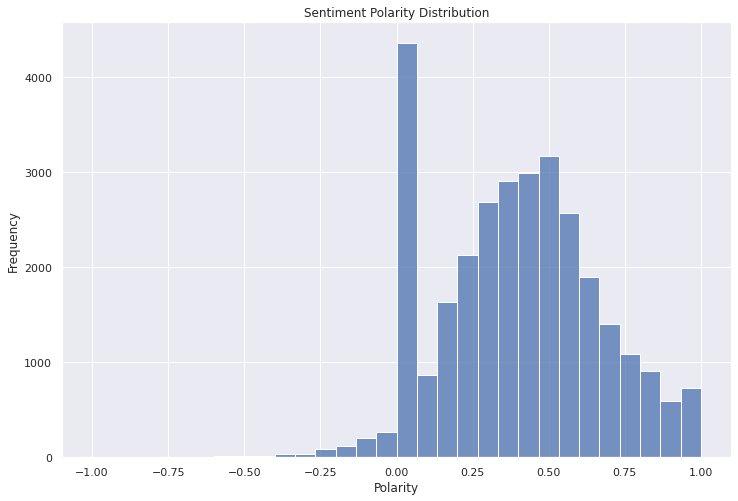

In [49]:
# Plotting the polarity distribution
fig, ax = plt.subplots(figsize=(12,8))
sent_dist = sns.histplot(data=reviews_df,
            x='polarity',
            bins=30)

ax.set(title='Sentiment Polarity Distribution',
      xlabel='Polarity',
      ylabel='Frequency')
plt.show()

fig.savefig('sent_dist.png')

The reviews sentiments follows a normal distribution centered at the 0.5! This means that in average, the review sentiments are just positive, with a smaller number of extremely positive reviews and slightly positive. We have a peak of neutral sentiments at 0, and some residual slightly negative sentiments. This is a interesting result, it seems that the majarity of peoples experiences with restaurants are pleasant. Also, the there is a peak in the reviews with sentiment polarity close to 0 positively. This tells us that a lot of the reviews does not carry any complement of complaining about the user experience. This reviews are probably just describing the experience in a neutral form.

Now let's split this dataframe into positive and negatives, so we can create a separated word cloud and see what is going on with those reviews.

In [42]:
neg_reviews = reviews_df[reviews_df['polarity'] < 0]
pos_reviews = reviews_df[reviews_df['polarity'] > 0]

neg_reviews.head()

review  \
168  O restaurante √© espetacular! Da bebida a comid...   
392  J√° sou cliente da rede Camarada h√° um bom temp...   
532  Fui atendida por Carlos Wellington, que √© muit...   
615  Lugar aconchegante e a comida deliciosa. O pas...   
654  Fui com amigos para tomarmos o chopp mas gelad...   

                                                  text  \
168  The restaurant is spectacular!Drink the food !...   
392  I've been a client from the companion network ...   
532  I was attended by Carlos Wellington, who is ve...   
615  Cozy place and the food delicious.The pastel a...   
654  I went with friends to take the chopp but Ice ...   

                                         processedText  polarity  
168  the restaurant is spectaculardrink the food in... -0.600000  
392  i've been a client from the companion network ... -0.014286  
532  i was attended by carlos wellington who is ver... -0.070833  
615  cozy place and the food deliciousthe pastel an... -0.200000  
654  i went with friends to take the chopp but ice ... -0.600000

In [34]:
pos_reviews.head()

review  \
0  O ambiente √© maravilhoso! E o atendimento do g...   
1  Muito bem atendidos pelo √Çngelo Atendimento √°g...   
2  Comida fant√°stica, muito bem servida e ambient...   
3  Culin√°ria de frutos do mar impec√°vel. Camar√£o ...   
4  Nota 10, atendente muito simp√°tica e prestativ...   

                                                text  \
0  The setting is wonderful!And the service of th...   
1  Very well attended by the √Çngelo service agile...   
2  Fantastic food, very well served and extremely...   
3  Good seafood cuisine.Shrimp to the delicious s...   
4  Note 10, very friendly and helpful attendant, ...   

                                       processedText  polarity  
0  the setting is wonderfuland the service of the...  0.535833  
1  very well attended by the √¢ngelo service agile...  0.318750  
2  fantastic food very well served and extremely ...  0.413333  
3  good seafood cuisineshrimp to the delicious se...  0.523333  
4  note  very friendly and helpful attendant call...  0.346167

###### Negative word cloud
Now we repeat the same procedure that we have done for creating the first word cloud.

In [40]:
# Gathering all the negative reviews
neg_rev_list = []

def get_neg_rev(row):
    neg_rev_list.append(row)
    return row

In [48]:
# Cleaning the texts and adding the reviews to a list
neg_reviews['review']=neg_reviews['review'].apply(clean_text)
neg_reviews['review'].apply(get_neg_rev)

TypeError: list indices must be integers or slices, not str

In [44]:
# Joining the list into a string
neg_rev = ' '.join(neg_rev_list)

In [53]:
# Instantiating the stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.update(["!", ".", ",", "(", ")"])               # Removing some punctuations

# Spliting the big string into its words
neg_tokens = word_tokenize(neg_rev)

# Using list comprehension to create a new list without the stopwords
neg_reviews = [neg_revs.lower() for neg_revs in neg_tokens if not neg_revs.lower() in stop_words]

In [9]:
neg_reviews[:100]

NameError: name 'neg_reviews' is not defined

Creating the word cloud

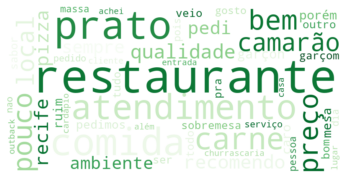

In [57]:
neg_cloud = WordCloud(max_words=50,
                         background_color='white',
                         prefer_horizontal=0.5,
                        width=800,
                        height=400,
                        colormap='Greens').generate(' '.join(neg_reviews))
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud_neg.png')

Well, if you know some portuguese you will realize that the majority of those words are not actually negative. There is some word has appears with low frequency with negative meaning, such as "bad", "therefore", "because".

As we saw that the amount of negative reviews is quite low, the "positive" word cloud problably will not be that much different from the general word cloud that we have already made. So, let's continue with the negative sentiments and make a bar plot with the frequencies.

In [55]:
# Let's calculate Term Frequency manually
TF = []

# This loop itereates through the set of filtered titles. A set is a data structure that stores only unique values
# It calculates how many each unique word appears in the filtered_titles
for word in set(neg_reviews):
    TF.append(neg_reviews.count(word))

# Transforming the set of unique words into a list
terms = list(set(neg_reviews))

# Creating a dataframe out of lists
neg_df_tf = pd.DataFrame(data=list(zip(terms, TF)), columns=['Term', 'Frequency'])
neg_df_tf.sort_values(by='Frequency', ascending=False)

Term  Frequency
440        comida        524
1190  atendimento        486
1698  restaurante        464
959           bem        386
28       ambiente        250
...           ...        ...
1674   friademora          2
1677         indo          2
1679         bela          2
1681    hospedado          2
3981        inv√©s          2

[3982 rows x 2 columns]

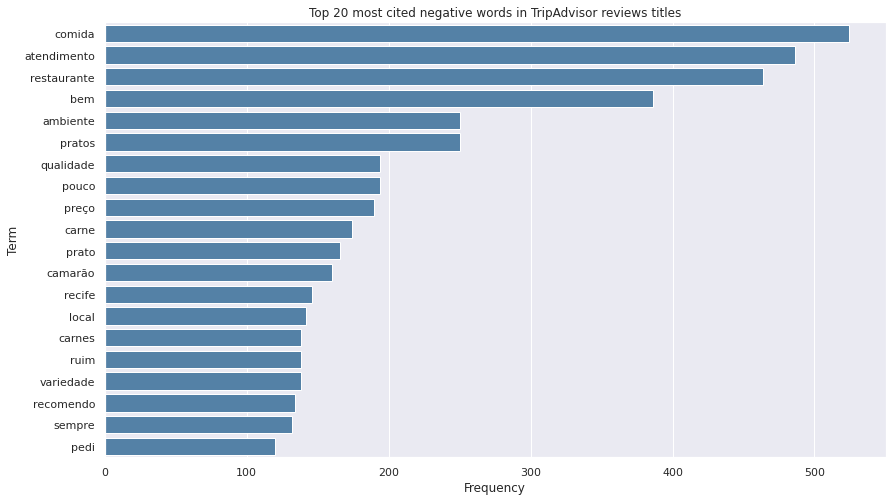

In [56]:
# Now lets redo the bar plot showing the top 20 words
df_tf_top_20 = neg_df_tf.sort_values(by='Frequency', ascending=False)[:20]
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_tf_top_20,
           x='Frequency',
           y='Term',
           color='steelblue',
           )
ax.set(title='Top 20 most cited negative words in TripAdvisor reviews titles',
      xlabel='Frequency')
plt.show()

Again, only few of those words carries truly negative feelings.

Maybe this is a problem with the polarity extractor, or problem with the translation or, most probably, the problem is generated when we are tokenizing the words and splitting then. The negative words probably come most in compound phrases, like bigrams and trigramns.